# CNN model for CIFAR-10 dataset with data augmentation

Based on Keras CIFAR-10 simple example: [Train a simple deep CNN on the CIFAR10 small images dataset](https://keras.io/examples/cifar10_cnn/)

In [1]:
DATA_AUGMENTATION = True

EXAMPLES_COUNT_PER_CLASS = 10

BATCH_SIZE = 32 # 32 examples in a mini-batch, smaller batch size means more updates in one epoch
EPOCHS = 100 # repeat 100 times

SEED = 23

import numpy
numpy.random.seed(SEED)

## Loading CIFAR-10 dataset

In [2]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train.shape, '=>', x_train.shape[0], 'train samples')
print('x_test shape:', x_test.shape, '=>', x_test.shape[0], 'test samples')

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
# y shapes are confusing (class name is an array with a number) => reshape it to vectors:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

classes = set(y_train)
class_count = len(classes)
print('Classes in y_train: ', classes)
print('Number of classes: %d' % class_count)

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) => 50000 train samples
x_test shape: (10000, 32, 32, 3) => 10000 test samples
y_train shape: (50000, 1)
y_test shape: (10000, 1)
Classes in y_train:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Number of classes: 10


## Display some examples from the training set for each class

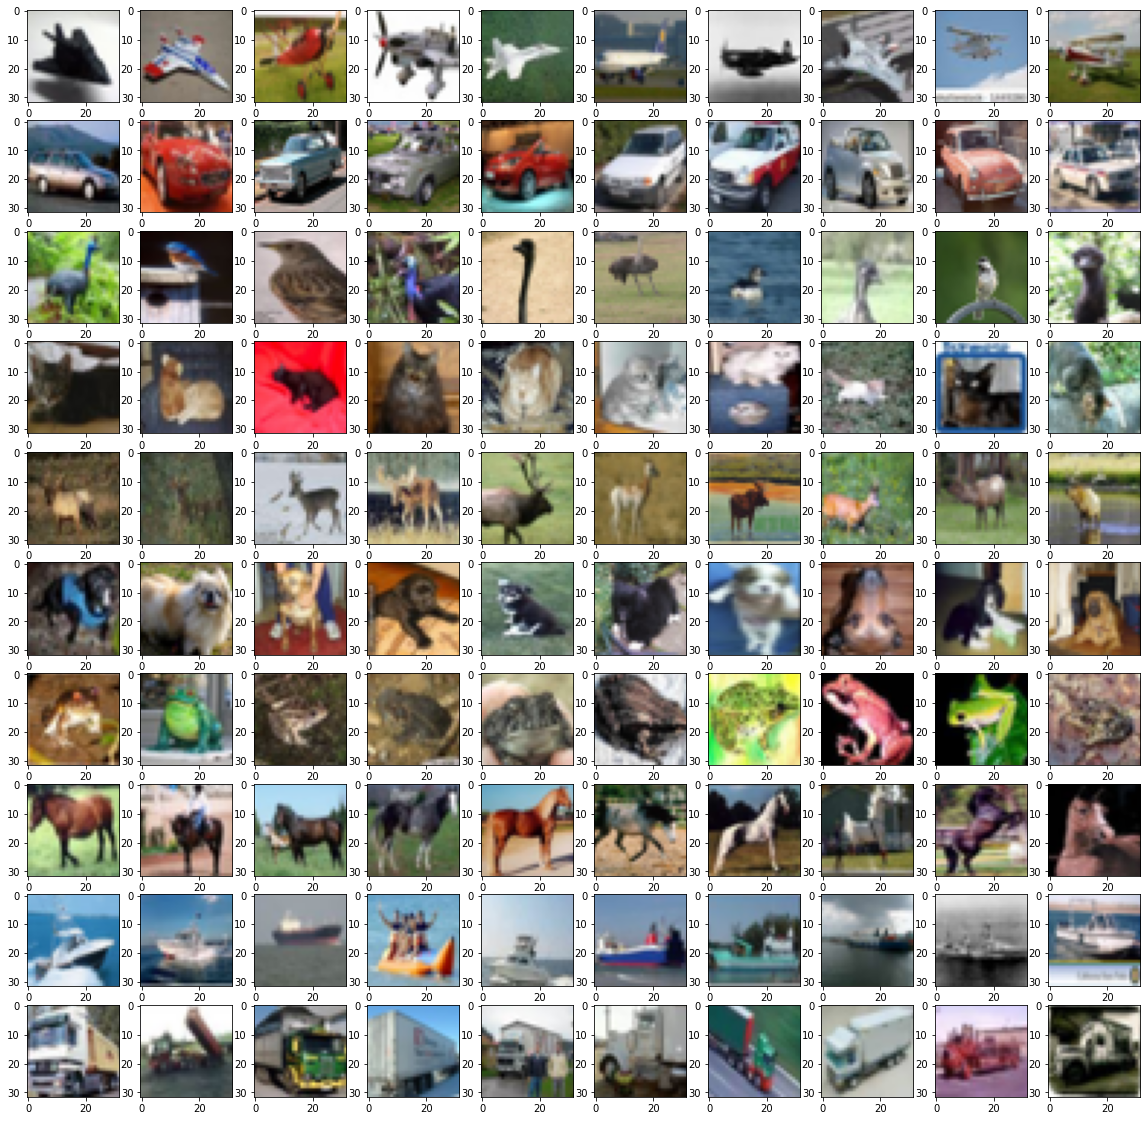

In [3]:
import math
import matplotlib.pyplot as plt

if EXAMPLES_COUNT_PER_CLASS > 0:
    plt.figure(figsize=(20, 20))
    for i in range(class_count):
        for j in range(EXAMPLES_COUNT_PER_CLASS):
            y_with_class_i = numpy.where(y_train[:] == i)[0]
            plt.subplot(class_count, EXAMPLES_COUNT_PER_CLASS, (i * EXAMPLES_COUNT_PER_CLASS) + (j + 1))
            plt.imshow(x_train[y_with_class_i[j]])
    plt.show()

## Scalling train/test datasets to [0, 1]

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("min: %f" % x_train[0].min(), "\nmax: %f" % x_train[0].max())  # Check values for the first image from the training set

min: 0.000000 
max: 1.000000


## One-hot encoding for softmax output layer

In [5]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, class_count)
y_test = to_categorical(y_test, class_count)

class_count = y_train.shape[1]
print('Number of classes: %d' % class_count)

print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

Number of classes: 10
y_train shape:  (50000, 10)
y_test shape:  (10000, 10)


## CNN model definition

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(class_count))
model.add(Activation('softmax'))

## Setting optimizer and loss function

In [7]:
from keras.optimizers import RMSprop

# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Model training with or without data augmentation (according to `DATA_AUGMENTATION` parameter)

In [8]:
from keras.preprocessing.image import ImageDataGenerator

if not DATA_AUGMENTATION:
    print('Training without data augmentation.')
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Training with real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                        steps_per_epoch=len(x_train) / BATCH_SIZE,
                        # steps_per_epoch must be provided because otherwise we get the error:
                        # ValueError: `steps_per_epoch=None` is only valid for a generator based on the `keras.utils.Sequence` class. Please specify `steps_per_epoch` or use the `keras.utils.Sequence` class.
                        epochs=EPOCHS,
                        validation_data=(x_test, y_test),
                        workers=4)

Training with real-time data augmentation.
Epoch 1/100
1562/1562 [==============================] - 289s 174ms/step - loss: 2.0251 - accuracy: 0.2474 - val_loss: 1.5086 - val_accuracy: 0.4483
Epoch 2/100
1562/1562 [==============================] - 273s 174ms/step - loss: 1.6075 - accuracy: 0.4165 - val_loss: 1.3606 - val_accuracy: 0.5101
Epoch 3/100
1562/1562 [==============================] - 273s 175ms/step - loss: 1.4806 - accuracy: 0.4606 - val_loss: 1.2646 - val_accuracy: 0.5482
Epoch 4/100
1562/1562 [==============================] - 273s 175ms/step - loss: 1.3938 - accuracy: 0.5001 - val_loss: 1.2056 - val_accuracy: 0.5767
Epoch 5/100
1562/1562 [==============================] - 275s 176ms/step - loss: 1.3161 - accuracy: 0.5325 - val_loss: 1.1819 - val_accuracy: 0.5834
Epoch 6/100
1562/1562 [==============================] - 275s 176ms/step - loss: 1.2601 - accuracy: 0.5527 - val_loss: 1.1176 - val_accuracy: 0.6037
Epoch 7/100
1562/1562 [==============================] - 275s 1

## Save model and its weights

In [9]:
#save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'keras_cifar10_trained_model.h5'
#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
#model_path = os.path.join(save_dir, model_name)
#model.save(model_path)
#print('Saved trained model at %s ' % model_path)

## Evaluate trained model

In [10]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 11s 36ms/step - loss: 0.7255 - accuracy: 0.7582
Test loss: 0.7254748344421387
Test accuracy: 0.7581999897956848
